Make simple snn to classify MNIST

In [21]:
import os
import time
import argparse
import sys
import datetime
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.cuda import amp
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from spikingjelly.activation_based import lava_exchange
from spikingjelly import visualizing


from spikingjelly.activation_based import neuron, layer, functional, monitor
from spikingjelly.activation_based import surrogate, encoding
from matplotlib import pyplot as plt
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


Define Model

In [2]:
class SNN(nn.Module):
    def __init__(self, tau):
        super().__init__()
        self.layer1 = nn.Sequential(
            layer.Linear(28*28, 10, bias=False),
            neuron.LIFNode(tau=tau, surrogate_function=surrogate.ATan())
        )
    def forward(self, x: torch.Tensor):
        # print(x.shape)
        return self.layer1(x)

Create a model with a default tau value

In [3]:
tau = 2.0 #membrane time constant. 
#^ A default value in some of the spikingjelly repo files.
model = SNN(tau=tau).to(device=device)

Download the MNIST dataset and make train and test datasets

In [4]:
data_dir='./data'
train_dataset = torchvision.datasets.MNIST(
    root=data_dir,
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)
test_dataset = torchvision.datasets.MNIST(
    root=data_dir,
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

In [5]:
batch_size=32
num_workers=10 #todo: see if this can be increased with more cores
train_data_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True
)
test_data_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=True
)

More settings

In [6]:
EPOCHS=50
AMP=True #automatic mixed precision training
lr= 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
out_dir = "./outputs/SLM"
encoder = encoding.PoissonEncoder()
timesteps = 25

Make settings for AMP and outputs

In [7]:
scaler = None
if AMP:
    scaler = amp.GradScaler()
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    print(f'Mkdir {out_dir}.')

writer = SummaryWriter(out_dir, purge_step=0)
with open(os.path.join(out_dir, 'args.txt'), 'w', encoding='utf-8') as args_txt:
    args_txt.write('\n')
    args_txt.write(' '.join(sys.argv))

Start training

In [8]:
functional.reset_net(model)
for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    for x, label in train_data_loader:
        x = x.to(device)
        x = torch.reshape(x, (batch_size, -1))
        label = label.to(device)
        label_onehot = F.one_hot(label, 10).float()

        if scaler is None:
            out_fr = 0.
            for t in range(timesteps):
                encoded_img = encoder(x)
                out_fr += model(encoded_img)
            out_fr = out_fr / timesteps
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()
        else:
            with amp.autocast():
                out_fr = 0.
                for t in range(timesteps):
                    encoded_img = encoder(x)
                    out_fr += model(encoded_img)
                out_fr = out_fr / timesteps
                loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        train_acc += (out_fr.argmax(1) == label).float().sum().item()

        functional.reset_net(model) #need to reset the snn before reuse
    print('epoch: ' + str(epoch) + '; loss' + str(train_loss))

epoch: 0; loss1469.1838662028313
epoch: 1; loss1085.8617819324136
epoch: 2; loss1022.22754304111
epoch: 3; loss989.1662621796131
epoch: 4; loss967.8891417682171
epoch: 5; loss950.6155417524278
epoch: 6; loss936.2021002061665
epoch: 7; loss928.6542583368719
epoch: 8; loss915.088821772486
epoch: 9; loss904.1025811471045
epoch: 10; loss905.1307405084372
epoch: 11; loss902.13954109326
epoch: 12; loss903.1334616616368
epoch: 13; loss903.7942631244659
epoch: 14; loss903.0179411694407
epoch: 15; loss902.4062617272139
epoch: 16; loss904.5912203453481
epoch: 17; loss902.8893027454615
epoch: 18; loss902.8670619875193
epoch: 19; loss903.1840238459408
epoch: 20; loss904.1912219710648
epoch: 21; loss903.9491427019238
epoch: 22; loss904.4405021779239
epoch: 23; loss902.6275444030762
epoch: 24; loss902.9611430428922
epoch: 25; loss904.5101028755307
epoch: 26; loss903.6550621539354
epoch: 27; loss904.6790618821979
epoch: 28; loss903.5169818550348
epoch: 29; loss903.2888236790895
epoch: 30; loss904.345

Save the SNN Model so that you do not have to retrain

In [9]:
input('are you sure you want to save the moel?')
file_dir = './Models/'
if not os.path.exists(file_dir):
    os.makedirs(file_dir)
    print(f'Mkdir {file_dir}.')
full_path = file_dir + '/SingleLayer_SNN.pt'
torch.save(model.state_dict(), f=full_path)

Load Model

In [10]:
file_dir = './Models/'
full_path = file_dir + '/SingleLayer_SNN.pt'
checkpoint = torch.load(f=full_path)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [11]:
#test the accuracy
model.eval()
test_loss = 0
test_acc = 0
test_samples = 0
with torch.no_grad():
    for x, label in test_data_loader:
        x = x.to(device)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], -1))
        label = label.to(device)
        label_onehot = F.one_hot(label, 10).float()
        out_fr = 0.
        for t in range(timesteps):
            encoded_img = encoder(x)
            out_fr += model(encoded_img)
        out_fr = out_fr / timesteps
        loss = F.mse_loss(out_fr, label_onehot)

        test_samples += label.numel()
        test_loss += loss.item() * label.numel()
        test_acc += (out_fr.argmax(1) == label).float().sum().item()
        functional.reset_net(model)
test_time = time.time()
# test_speed = test_samples / (test_time - train_time)
test_loss /= test_samples
test_acc /= test_samples
# writer.add_scalar('test_loss', test_loss, epoch)
# writer.add_scalar('test_acc', test_acc, epoch)
print(test_acc)

0.9233


Get Spike Counts

In [12]:
spike_monitor = monitor.OutputMonitor(model, neuron.LIFNode)

In [13]:
spike_monitor = monitor.OutputMonitor(model, neuron.LIFNode)
#test the accuracy
start_time = time.time()
model.eval()
test_loss = 0
test_acc = 0
test_samples = 0
z = 0
with torch.no_grad():
    for x, label in test_data_loader:
        x = x.to(device)
        # print(x.shape)
        x = torch.reshape(x, (x.shape[0], -1))
        label = label.to(device)
        label_onehot = F.one_hot(label, 10).float()
        out_fr = 0.
        for t in range(timesteps):
            encoded_img = encoder(x)
            out_fr += model(encoded_img)
        out_fr = out_fr / timesteps
        loss = F.mse_loss(out_fr, label_onehot)

        test_samples += label.numel()
        test_loss += loss.item() * label.numel()
        test_acc += (out_fr.argmax(1) == label).float().sum().item()
        functional.reset_net(model)
        # if z > 1:
        #     break
        # z += 1
test_time = time.time()
# test_speed = test_samples / (test_time - train_time)
test_loss /= test_samples
test_acc /= test_samples
# writer.add_scalar('test_loss', test_loss, epoch)
# writer.add_scalar('test_acc', test_acc, epoch)
print(test_acc)
print(test_samples)
print(model)
total_spikes = 0
for tens in spike_monitor.records:
    tensnp = tens.cpu().numpy()
    total_spikes += np.sum(tensnp)
print('total spikes: ' + str(total_spikes))
print(f'spike_seq_monitor.records=\n{len(spike_monitor.records)}')
print('total time steps: ' + str(timesteps*test_samples))

0.9236
10000
SNN(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=False)
    (1): LIFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch, tau=2.0
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
  )
)
total spikes: 240899.0
spike_seq_monitor.records=
7825
total time steps: 250000


Calculate Power

In [14]:
neurons = 10
Pi = 0.25
Pb = 4/1000
Pn = 0.0234 #watts (J per second)
Ps = 11.3 * (10**-9)

power = Pi + Pb + (neurons * Pn) + (total_spikes * Ps)
print('total power (watts): ' + str(power))

total power (watts): 0.49072215869999997


In [15]:
print(spike_monitor.records[0].shape)
print(len(spike_monitor.records))
print(f'spike_seq_monitor.monitored_layers={spike_monitor.monitored_layers}')
for p in model.parameters():
    print(p.shape)
    print(len(p))

torch.Size([32, 10])
7825
spike_seq_monitor.monitored_layers=['layer1.1']
torch.Size([10, 784])
10


Visualize the output

In [16]:
batch_size=1
num_workers=10 #todo: see if this can be increased with more cores
train_data_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True
)
test_data_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=True
)

In [19]:
spike_monitor = monitor.OutputMonitor(model, neuron.LIFNode)
#test the accuracy
start_time = time.time()
model.eval()
test_loss = 0
test_acc = 0
test_samples = 0
out_list = []
in_list = []
v_list = []
image_data = 0
with torch.no_grad():
    for x, label in test_data_loader:
        image_data = x.numpy()
        x = x.to(device)
        x = torch.reshape(x, (x.shape[0], -1))
        label = label.to(device)
        label_onehot = F.one_hot(label, 10).float()
        out_fr = 0.
        for t in range(timesteps):
            encoded_img = encoder(x)
            in_list.append(encoded_img.cpu().squeeze(0).numpy())
            out = model(encoded_img)
            out_list.append(out.cpu().squeeze(0).numpy())
            out_fr += out
            v_list.append((model.layer1[1].v).cpu().squeeze(0).numpy())
        out_fr = out_fr / timesteps
        print(out_fr)
        functional.reset_net(model)
        break


print(in_list[0].shape)
print(v_list[0].shape)
print(out_list[0].shape)

in_np = np.stack(in_list, axis=0) #axis 0 should be the timestep
v_np = np.stack(v_list, axis=0) #axis 0 should be the timestep
out_np = np.stack(out_list, axis=0) #axis 0 should be the timestep
print(in_np.shape)
print(v_np.shape)
print(out_np.shape)
print(np.squeeze(image_data).shape)
np.savetxt(fname="./Output_Image_Data/input_spikes.txt", X=in_np)
np.savetxt(fname="./Output_Image_Data/voltages.txt", X=v_np)
np.savetxt(fname="./Output_Image_Data/output_spikes.txt", X=out_np)
np.savetxt(fname="./Output_Image_Data/img_data.txt", X=np.squeeze(image_data))
# f_in = open("./Output_Image_Data/input_spikes.txt", 'x')
# f_v = open("./Output_Image_Data/voltages.txt", 'x')
# f_out = open("./Output_Image_Data/output_spikes.txt", 'x')
# f_im = open("./Output_Image_Data/img_data.txt", 'x')
example = np.loadtxt(fname="./Output_Image_Data/input_spikes.txt")
print(example.shape)

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
(784,)
(10,)
(10,)
(25, 784)
(25, 10)
(25, 10)
(28, 28)
(25, 784)


Visualize the arrays using appropriate graphs

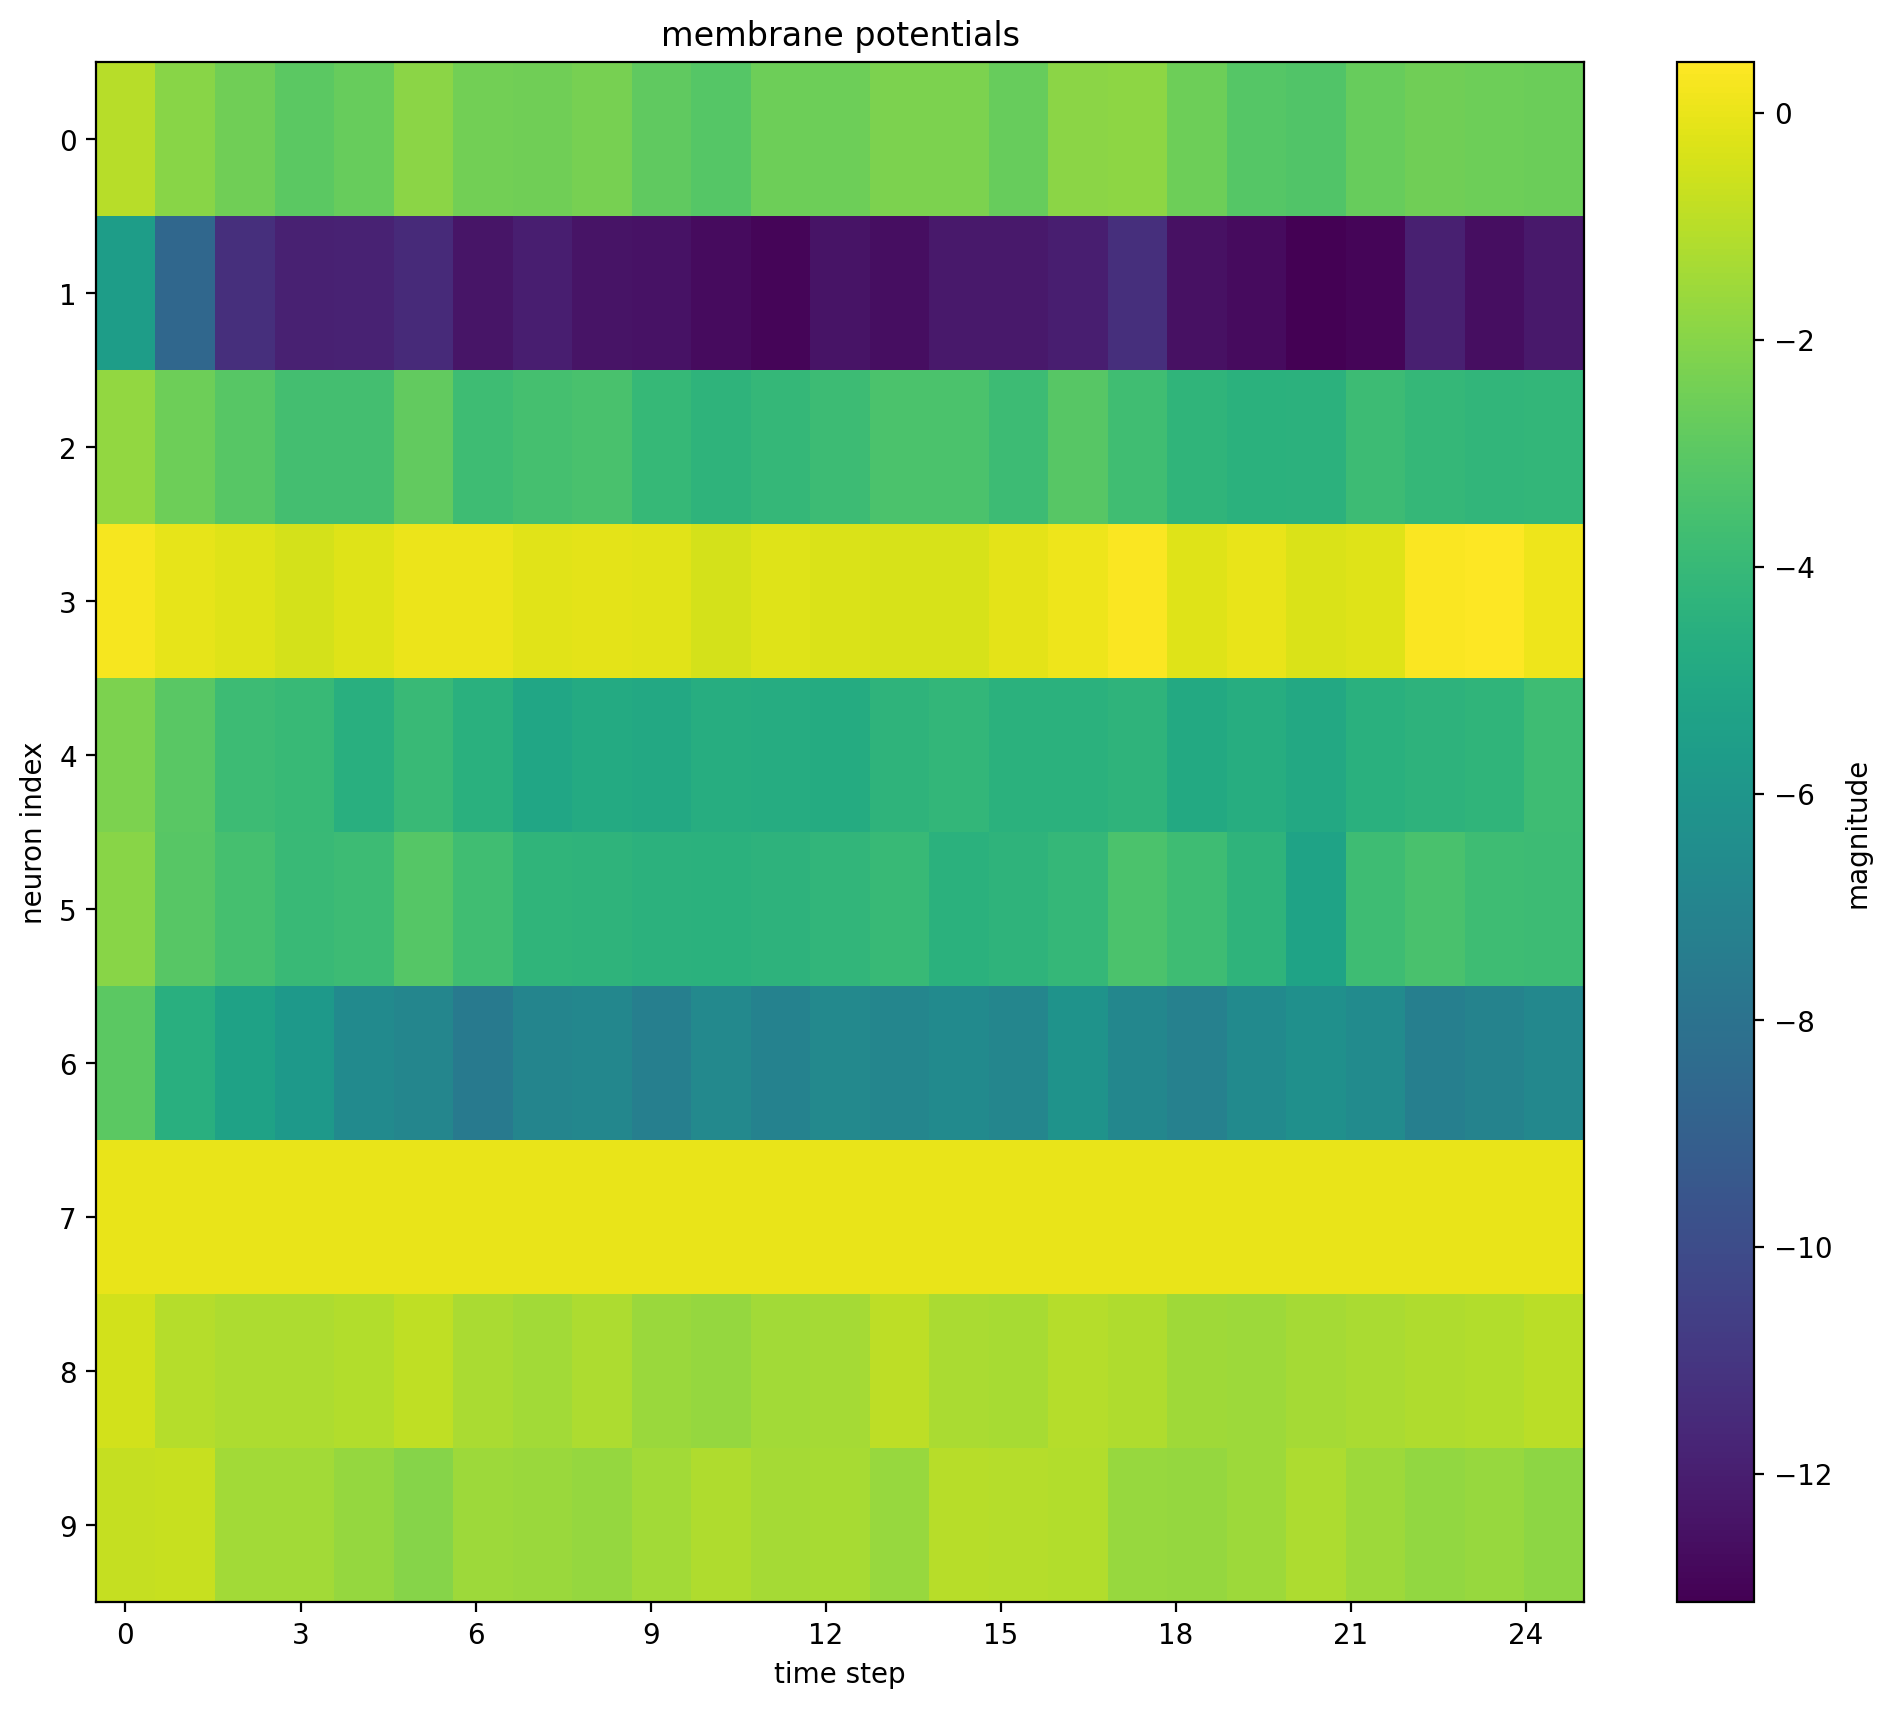

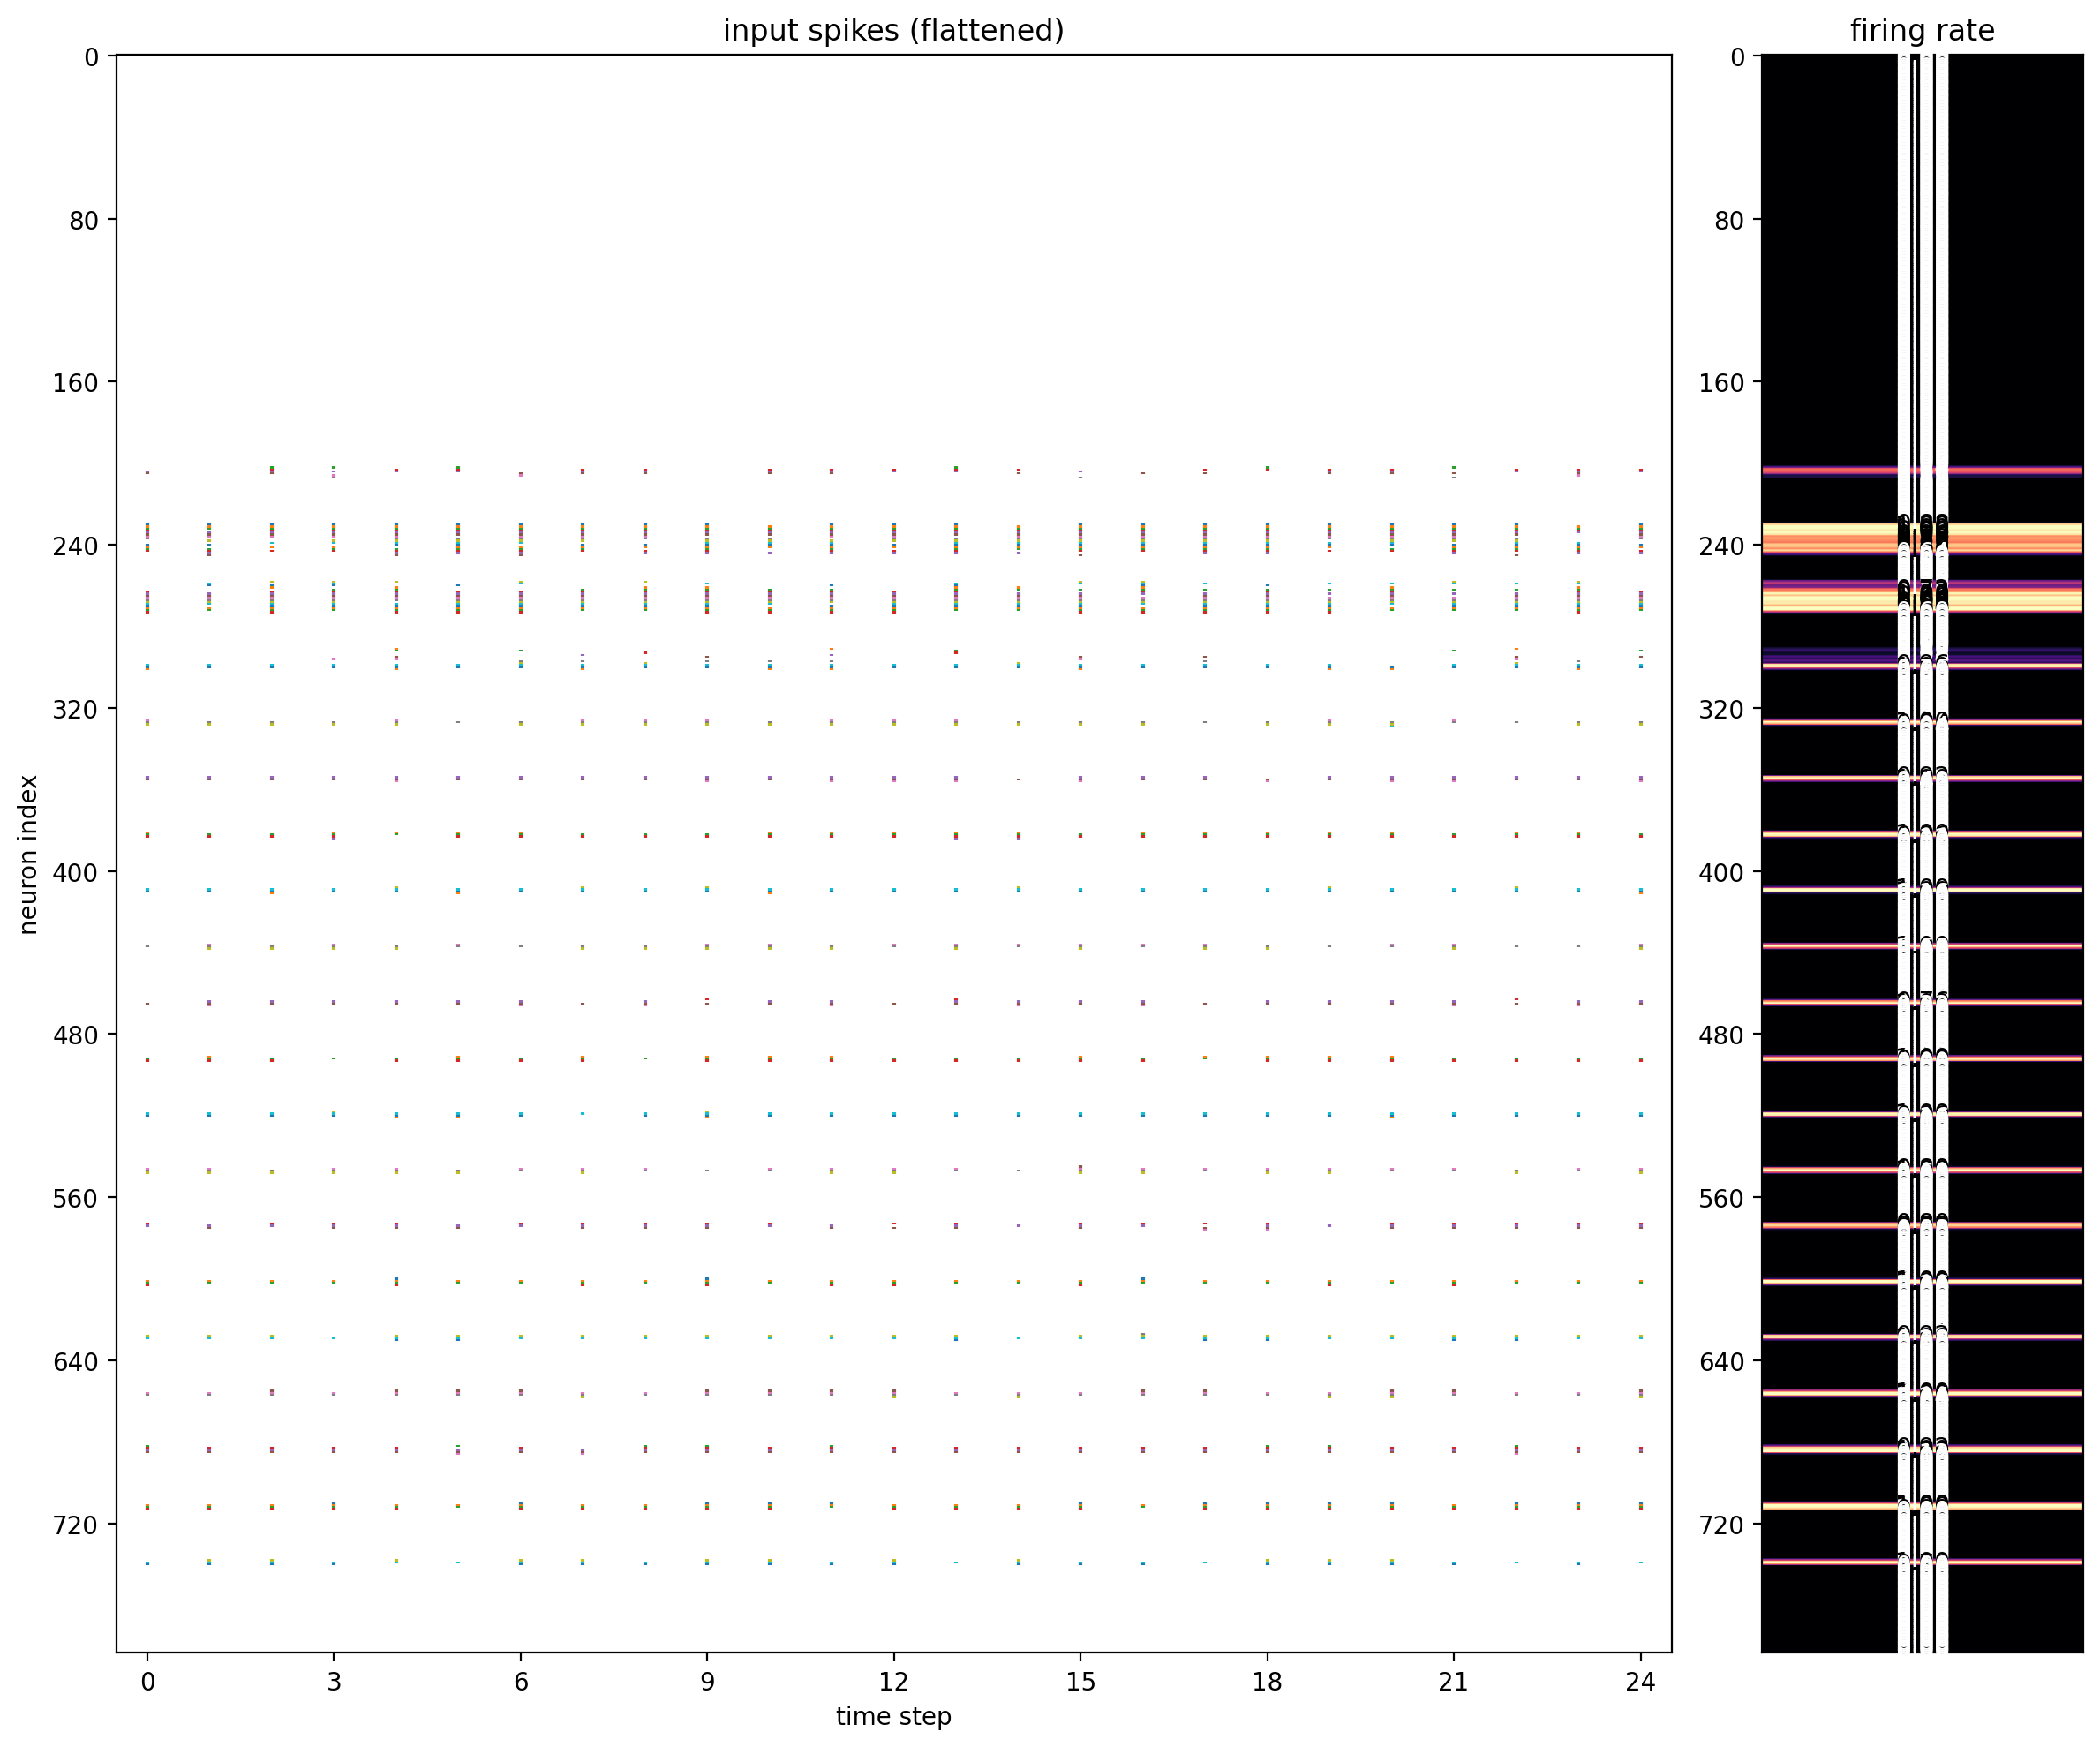

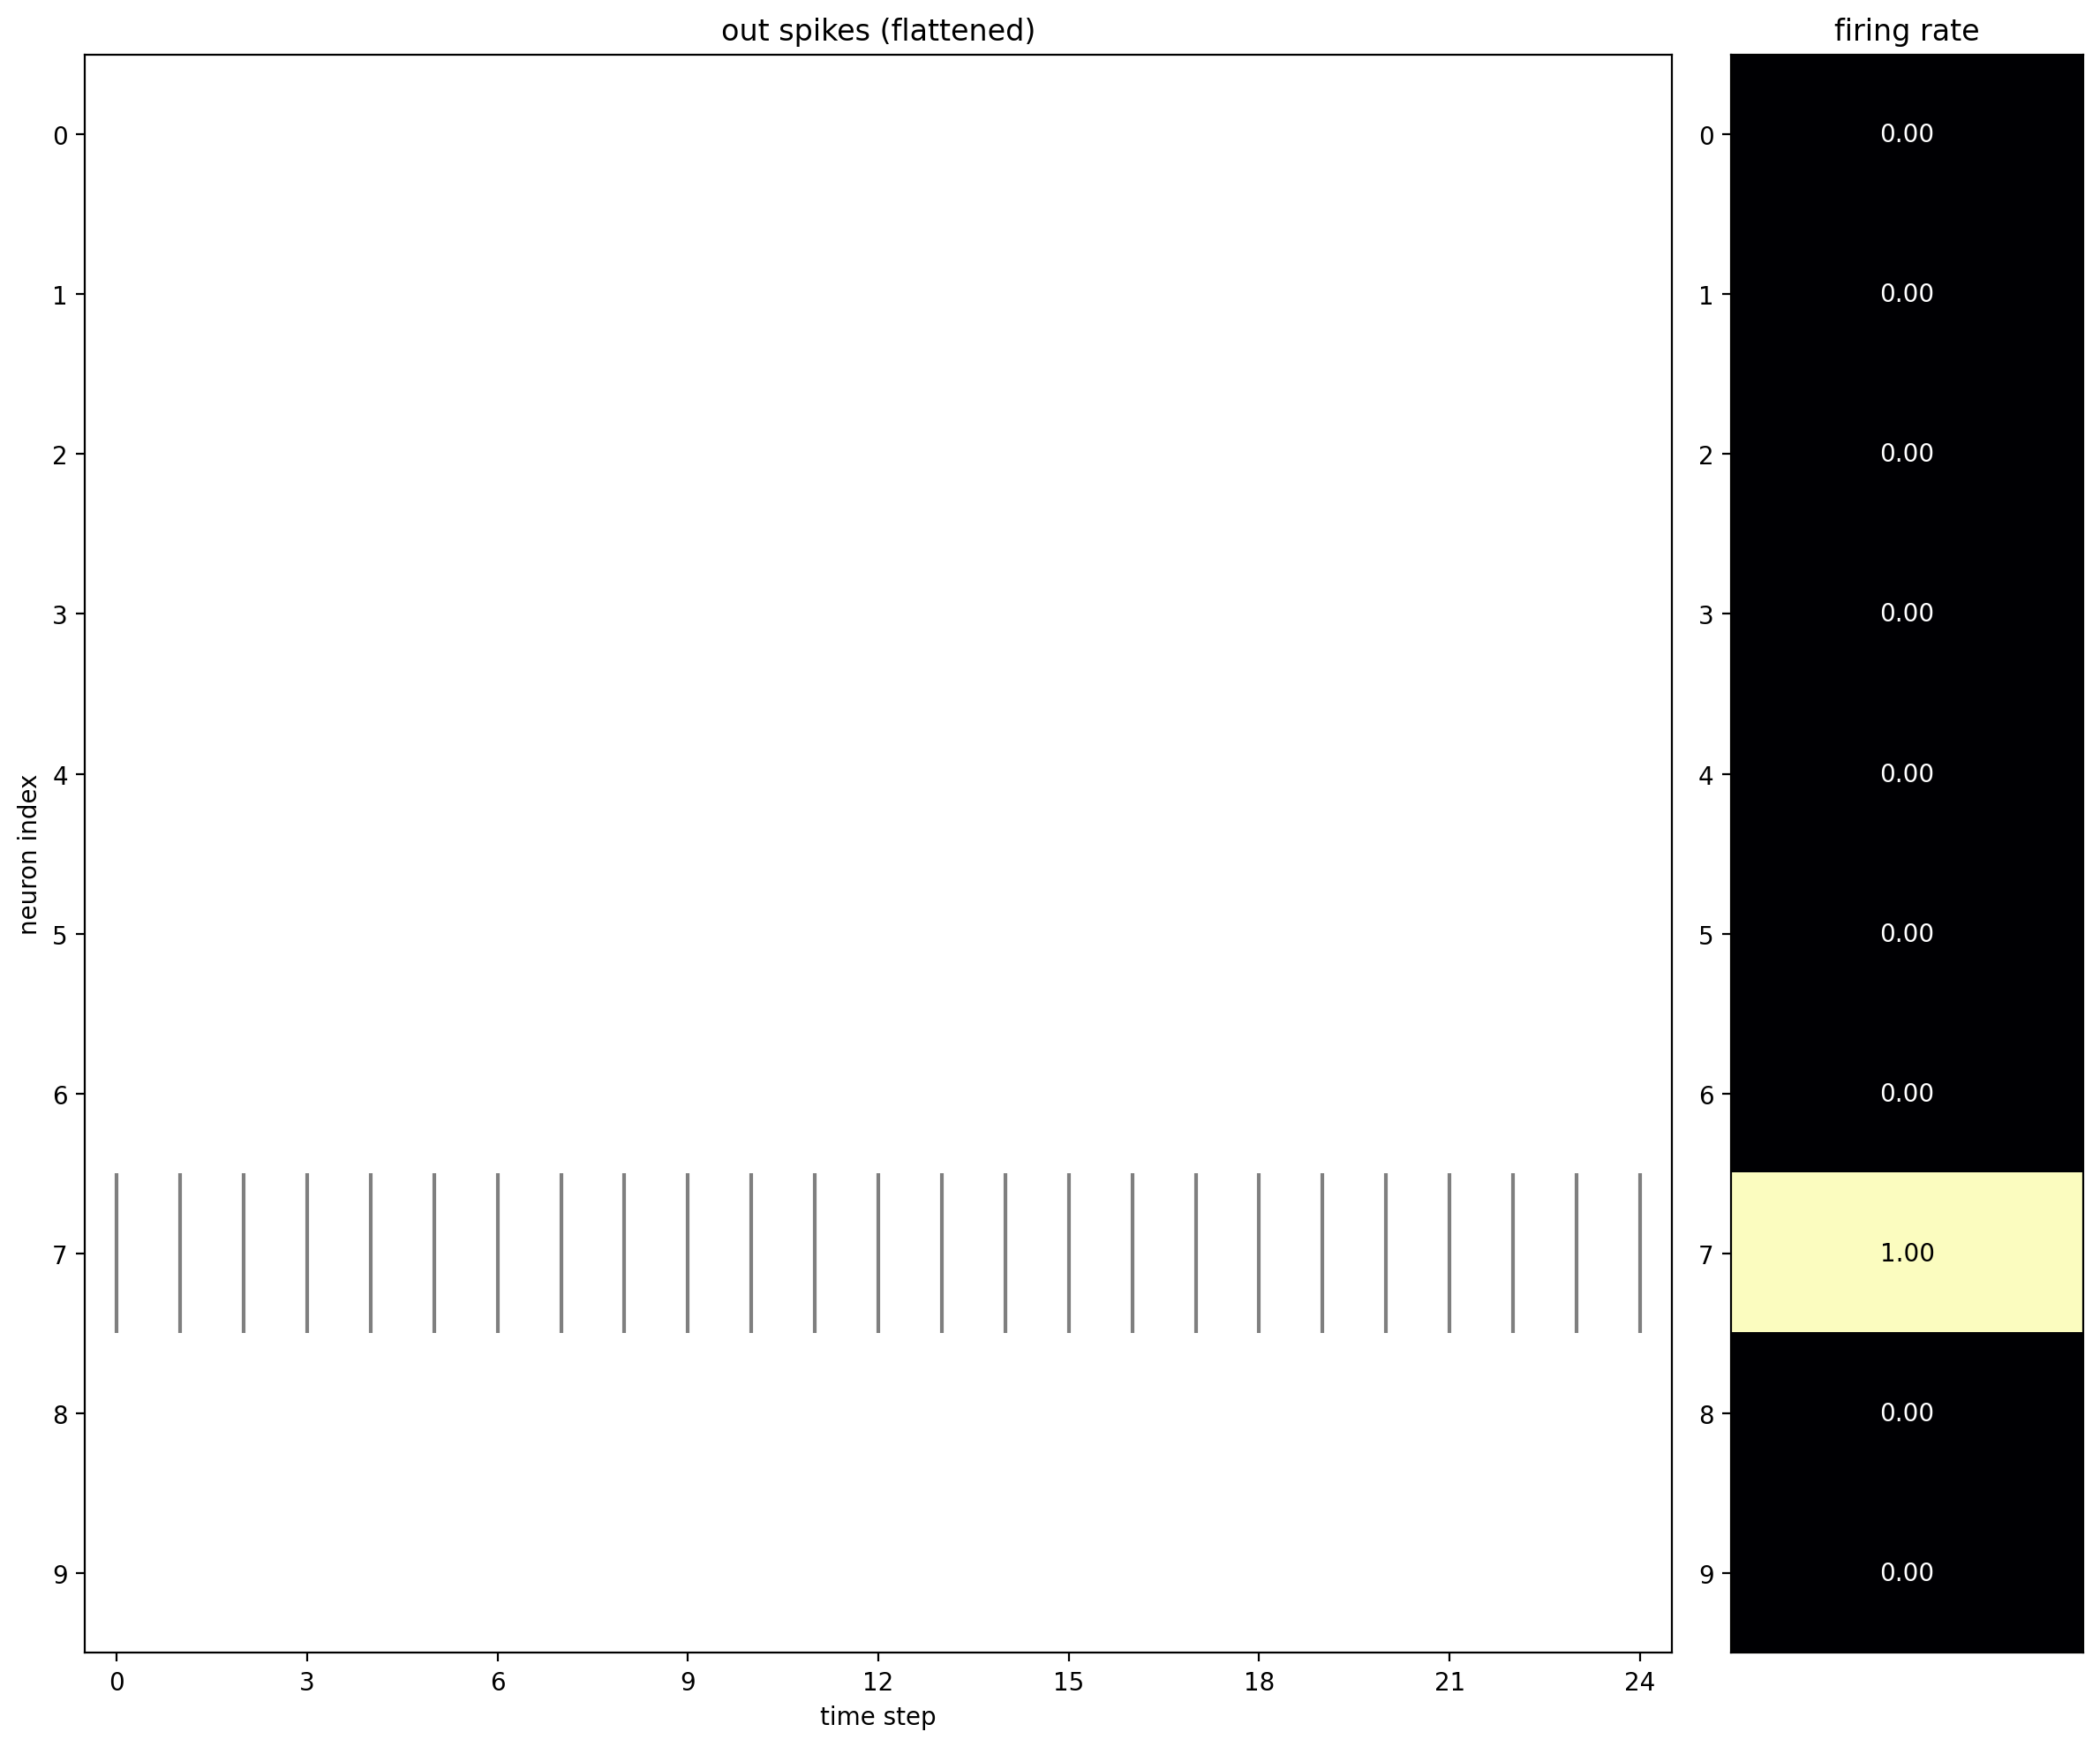

In [25]:
visualizing.plot_2d_heatmap(array=v_np, title='membrane potentials', xlabel='time step', ylabel='neuron index', int_x_ticks=True, x_max=timesteps, figsize=(12,8), dpi=200)
visualizing.plot_1d_spikes(spikes=in_np, title='input spikes (flattened)', xlabel='time step', ylabel='neuron index', figsize=(12,8), dpi=200)
visualizing.plot_1d_spikes(spikes=out_np, title='out spikes (flattened)', xlabel='time step', ylabel='neuron index', figsize=(12,8), dpi=200)
plt.show()